In [1]:
###############################################################################

from IPython.core.interactiveshell import InteractiveShell
import jupyternotify
import folium
import matplotlib.pyplot as plt
import nest_asyncio
import numpy as np
import pandas as pd
from selenium import webdriver

InteractiveShell.ast_node_interactivity = "all"
get_ipython().register_magics(jupyternotify.JupyterNotifyMagics)
nest_asyncio.apply()

<IPython.core.display.Javascript object>

In [2]:
%%notify
df = pd.read_parquet('data.parquet')

<IPython.core.display.Javascript object>

In [3]:
## Break down time information
df['Date (Month)'] = df.Date.dt.to_period('M')
df['Date (Week)'] = df.Date.dt.to_period('w')
df['Week Number'] = df.Date.dt.isocalendar().week.astype(int)
df['Month Number'] = df.Date.dt.month.astype(int)
df['Year'] = df.Date.dt.year.astype(int)

In [4]:
def top5():
    figure = pd.pivot_table(
        df,
        index='Date (Month)',
        columns='Category',
        values='Cents',
        aggfunc='sum',
        margins=True)
    figure = figure.T.sort_values('All', ascending=False).T
    figure = figure.drop(columns='All')
    figure = figure.drop(index='All')

    ## Change units to Millions of DOLLARS
    figure = figure/100/10**6

    ## Select top 4 categories
    figure = figure.iloc[:,:4]

    figure.plot(kind='line', figsize=(10,3))
    plt.title('Total Sales by Month (Top 4 Categories)')
    plt.ylabel('Millions of Dollars')
    plt.xlabel('')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05,1));


def map_proportion():
    figure5 = pd.pivot_table(
        df,
        index='County',
        columns='Category',
        values='Cents',
        aggfunc='sum',
        margins=True,
    )

    figure5.head()

    ## Make feature
    ratio = '\nProportion Whiskey\n(Among Vodka and Whiskey)'
    figure5['All'] = figure5.Whiskey + figure5.Vodka
    figure5[ratio] = figure5.Whiskey/figure5.All

    ## Find average Long-Lat for each county (weighted by # purchases)
    figure5_location = pd.pivot_table(
        df,
        index='County',
        values=['Longitude','Latitude'],
        aggfunc='mean')

    figure5 = figure5.merge(figure5_location, left_index=True, right_index=True)

    figure5.plot.scatter(
        x = 'Longitude',
        y = 'Latitude',
        c = ratio,
        s = 5000 * (figure5.All / figure5.All.max())**0.5, # Size (Area) by Total Expenditure
        alpha = 0.4,
        colormap = 'YlOrBr', #YlOrBr_r
        figsize=(10,5),
    );
    plt.title(
        'Proportion Spent on Whiskey Among Vodka and Whiskey Sales\n'
        '(Area Sized by Combined Expenditure)'
    );

def plot_item(item):
    figure = df[df.Item.str[:len(item)]==item.title()]
    figure = pd.pivot_table(
        figure,
        index='Date (Month)',
        values='Cents',
        aggfunc='sum',
    )
    figure = figure/10**6 # Dollars -> Millions

    figure.plot(kind='line', legend=None, figsize=(10,2))
    plt.title(f'Monthly Sales of {item}')
    plt.ylabel('Millions of Dollars')
    plt.xlabel('');
    plt.show();

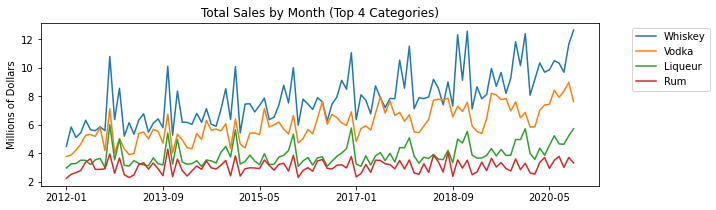

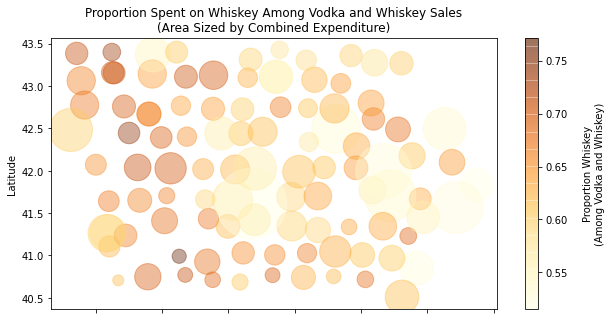

In [5]:
top5()
map_proportion() # See also 3-choropleth.ipynb

Text(0.5, 1.0, 'Average Sales by Week (Top 4 Categories)')

Text(0, 0.5, 'Millions of Dollars')

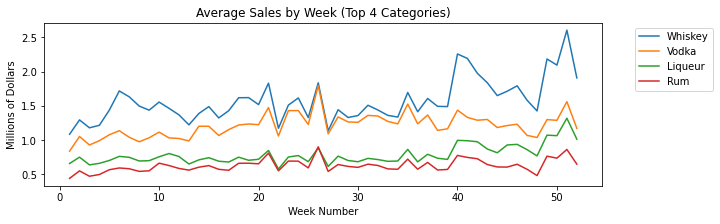

<IPython.core.display.Javascript object>

CPU times: user 17.6 s, sys: 26.1 s, total: 43.7 s
Wall time: 56.5 s


In [6]:
%%time
%%notify

figure = pd.pivot_table(
    df[df.Year<=2019], # Year 2020 not complete
    index='Week Number',
    columns='Category',
    values='Cents',
    aggfunc='sum',
    margins=True,
)

## Divide by number of years to get average
figure = figure/len(df.Year.unique())

## Select top 4 categories
figure = figure.T.sort_values('All', ascending=False).T
figure = figure.drop(columns='All')
figure = figure.drop(index=['All',53])
figure = figure.iloc[:,:4]

## Change units to Millions of DOLLARS
figure = figure/100/10**6

## Correct for 5% sample
# figure = figure*20 # <===== Do not include if using data.parquet

figure.plot(kind='line', figsize=(10,3))
# figure.mean(axis=1).plot(kind='line', c='k', linewidth=4, label='Average')
plt.title('Average Sales by Week (Top 4 Categories)')
plt.ylabel('Millions of Dollars')
plt.legend(loc='upper left', bbox_to_anchor=(1.05,1));

figure = pd.pivot_table(
    df, # Include year 2020
    index='Week Number',
    values='Cents',
    columns='Year',
    aggfunc='sum',
).iloc[:-1] # Drop week 53

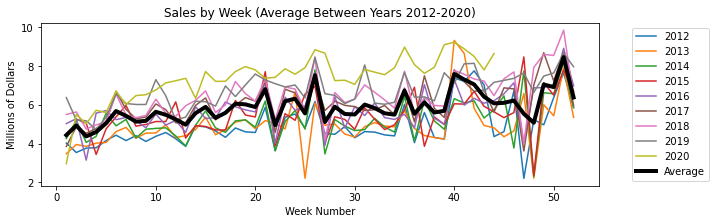

In [7]:
figure = pd.pivot_table(
    df, # Include year 2020
    index='Week Number',
    values='Cents',
    columns='Year',
    aggfunc='sum',
).iloc[:-1] # Drop week 53

## Change units to Millions of DOLLARS
figure = figure/100/10**6

## Correct for 5% sample
# figure = figure*20 # <===== Do not include if using data.parquet

figure.plot(kind='line', figsize=(10,3))
figure.mean(axis=1).plot(kind='line', c='k', linewidth=4, label='Average')

plt.title('Sales by Week (Average Between Years 2012-2020)')
plt.ylabel('Millions of Dollars')
plt.legend(loc='upper left', bbox_to_anchor=(1.05,1));

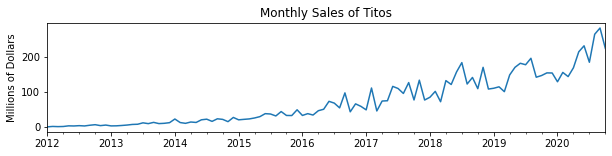

CPU times: user 10.7 s, sys: 8.45 s, total: 19.1 s
Wall time: 23.2 s


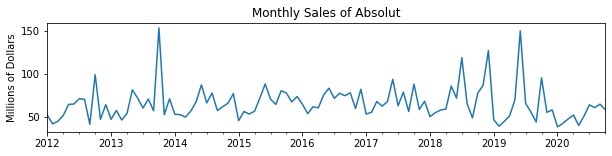

CPU times: user 9.84 s, sys: 7.02 s, total: 16.9 s
Wall time: 18.8 s


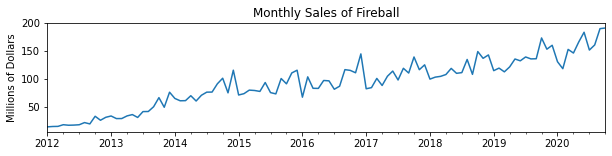

CPU times: user 9.51 s, sys: 4.66 s, total: 14.2 s
Wall time: 15.9 s


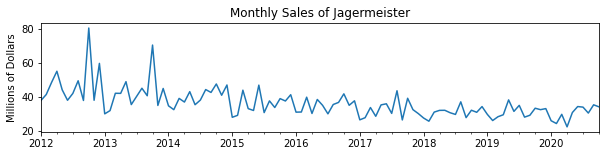

CPU times: user 9.39 s, sys: 4.66 s, total: 14.1 s
Wall time: 16.5 s


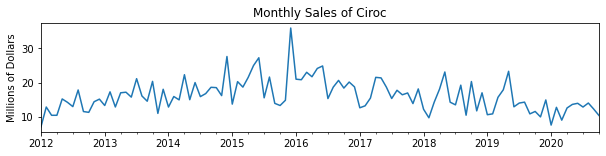

CPU times: user 11.3 s, sys: 8.87 s, total: 20.1 s
Wall time: 23.7 s


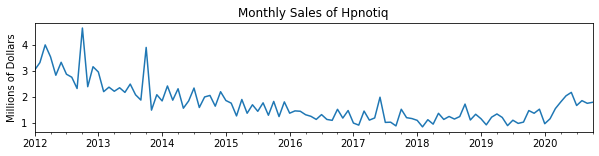

CPU times: user 12.7 s, sys: 5.56 s, total: 18.3 s
Wall time: 21 s


In [8]:
%time plot_item('Titos')
%time plot_item('Absolut')
%time plot_item('Fireball')
%time plot_item('Jagermeister')
%time plot_item('Ciroc')
%time plot_item('Hpnotiq')

# Graph of sales history for a survey of 462 product lines

In [11]:
lines = (
    'aberfeldy absente absolut adelaides admiral adult after agavero alban ale a'
    'll aloha altos amore amsterdam antique apples ardbeg arrow at atomic authen'
    'tic avion badel baileys bakon balvenie barenjager barton bastille bayou bee'
    'feater belvedere benchmark berentzen bernheim bing bird blackberries blackh'
    'eart blantons blast blossom bols bombay boodles book bookers born bowman bo'
    'wmore brendans brooks bros bubble buchanan bulleit burnetts burst bush bush'
    'mills buttershots cabin cabrito caliber calico california calumet calvert c'
    'alypso camp cana capel captain caravella cardhu carolans caskmates castillo'
    ' cazadores celtic chair chambord chamisul chartreuse cherries chila chili c'
    'hivas chopin cien cincoro ciroc clase clasico clearheart clement climax cly'
    'de cody collins comisario commanders cookie cotton courvoisier cove cow cra'
    'ft craig crave creamer crow crushed cruzan cuervo cupcake dalwhinnie david '
    'daviess deep dekuyper deleon derby dewars dickel dill distiller dom donut d'
    'oor doublewood dress dual dubliner dulce eagle early eddy effen eh elijah e'
    'lit ella elmer envy eoy evan everclear exotico ezra farm fat fee figenza fi'
    'nlandia fireball firefly fleischmanns float fluffed for forbidden forester '
    'fox frappachata free frida frost galliano garioch generaciones germain gilb'
    'eys gingers glazed glenfarclas glenfiddich glenlivet glenmorangie gluten go'
    'diva goose gordons grapevine grouse gunpowder hakushu handmade hangar hart '
    'hatozaki hawkeye hayden haymans hendricks henry herradura hibiki hiram hols'
    'tein horchata hornitos hpnotiq hunter il ila infused iowish irishman ivory '
    'jameson jane jay jeffersons jelly jeremiah jerry jimador johnnie jose jr ju'
    'an juarez judge juggs julio kahlua kessler ketel kilbeggan kinky kirk kiss '
    'knob korbel kraken kru ksbw kuhl lagavulin laphroaig larceny lasanta lbl le'
    'gendary leguas loco loconut loopy lord los love lucid lucy luksusowa lunazu'
    'l luscious makers malibu malted mandrin mangoes margaritaville marshmallow '
    'martell masson mayor mays mcclelland mcgillicuddys mckenna mediterranean me'
    'nage mentholmint michters milagro milk millet minichatas minze monte montez'
    'uma morgan morin mothers mozart mr mt nadurra nelson nicholson nights north'
    'ern nuvo oakheart oath oban obtainium ohranj olives olmeca opulent oranges '
    'orchard ornament orphan over overholt own package pact paddy paloma paradis'
    ' parrot patch peachtree peak pearl peligroso penthouse petal piehole pike p'
    'innacle plume plymouth pop popcorn popov powers prickly privilege pucker pu'
    'lteney quarter quinta rabbit rain rakija ramon razberi razz rebel recipe re'
    'dbreast redemption relska remus repeal replica revel reyka rich riegers rip'
    ' rittenhouse riva roca ronrico rothman rts rumchata rumhaven rumple ryan ry'
    'ans salvadors sangrita sapphire sauza scorpion seagram seal shady shellback'
    ' shortcake shots siete singleton sister skinnygirl skol sljivovica smirnoff'
    ' smith smoked sorbet sorrento sourced sours spell spicebox spot stag stagg '
    'state states stoke stolichnaya strawberries stuff sugarland sundae svedka s'
    'weeney takovo talisker tanqueray tarantula tesoro tf tgi tgif tgifridays th'
    'rones tim time times tippy titos tn tooters torada tortilla trace tradicion'
    'al tramonto travis trois tullamore twenty twist ultimate uv vics viniq viol'
    'ette voli wears wedding weed weller whistler whitetail windsor winkle winst'
    'on wisconsin woodford writers yb yell yellowstone you yukon zacapa zang zar'
    'co zero zing'
).split()

462

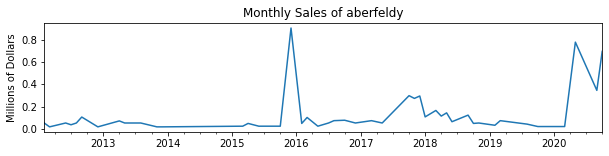

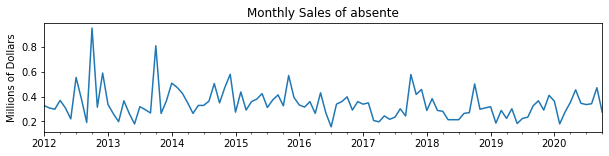

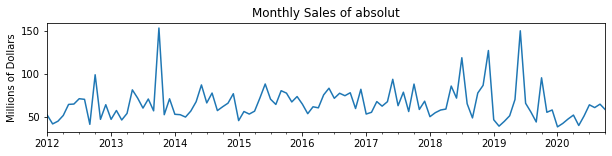

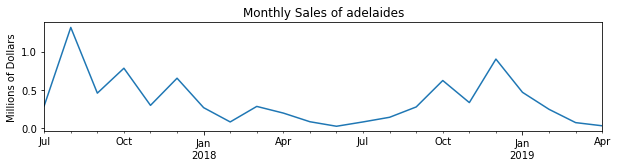

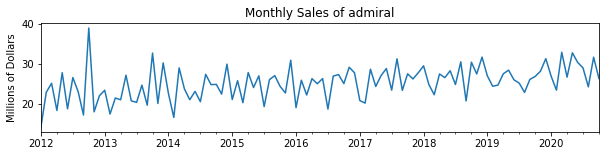

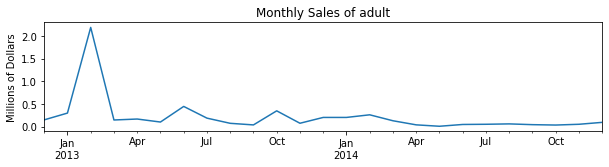

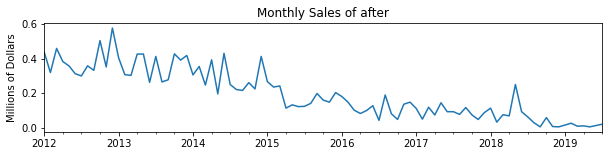

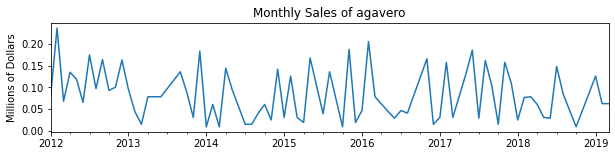

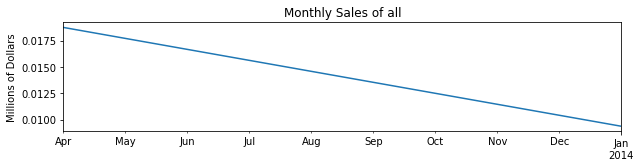

/Users/sunderland20a/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1136: UserWarning: Attempting to set identical left == right == 600.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


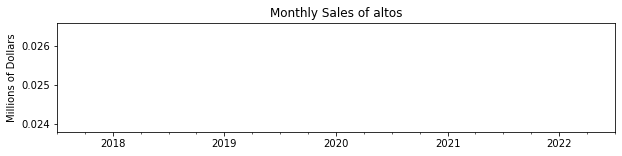

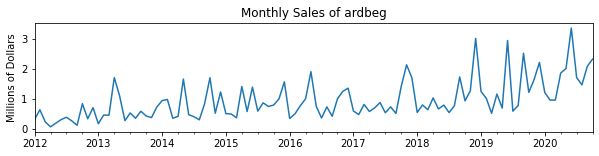

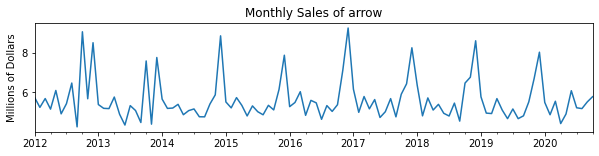

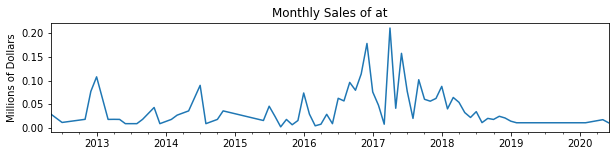

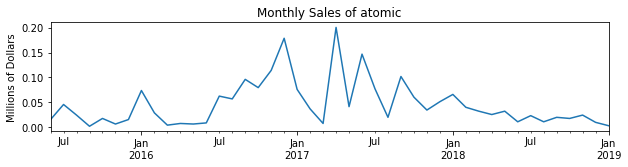

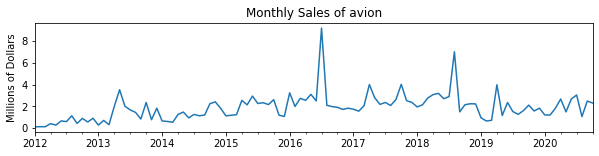

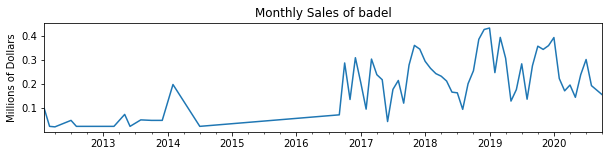

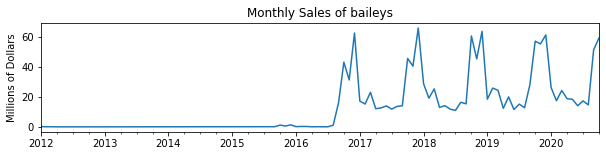

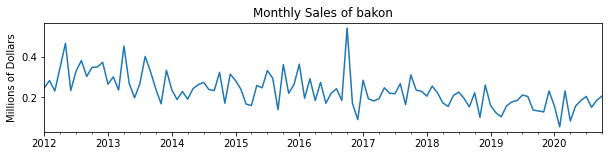

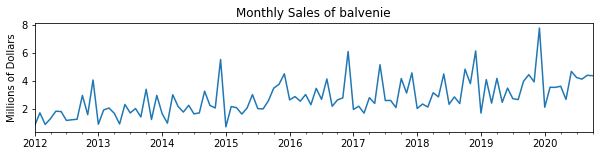

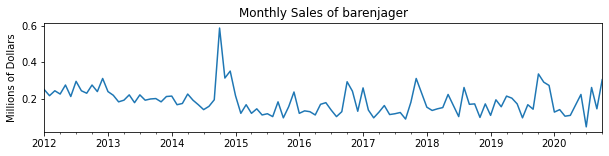

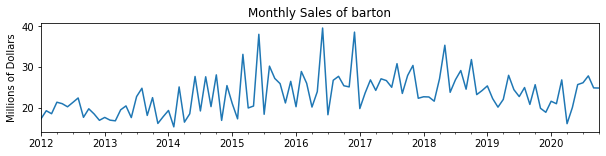

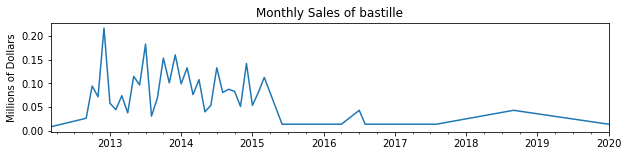

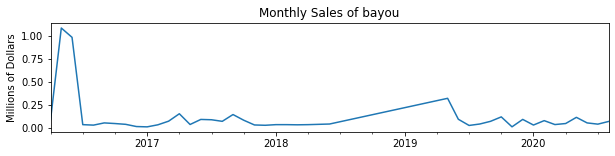

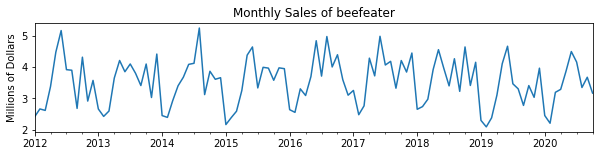

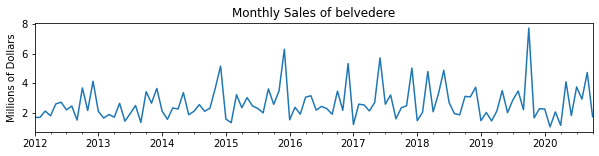

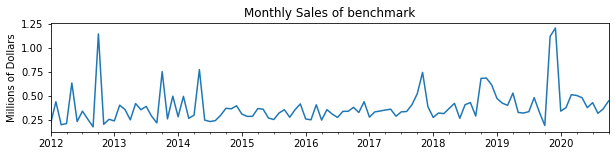

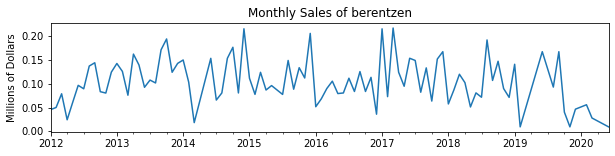

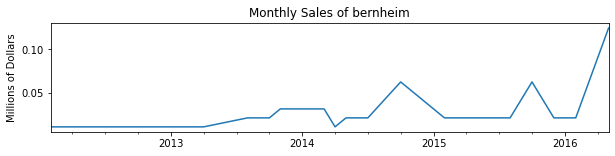

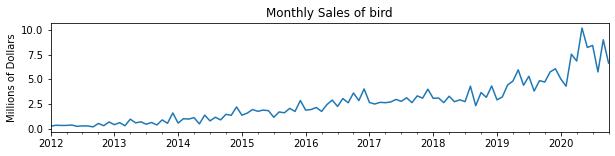

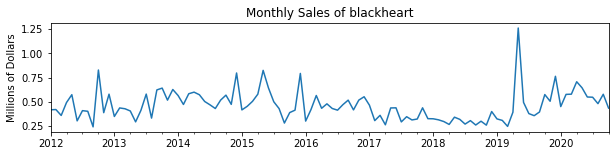

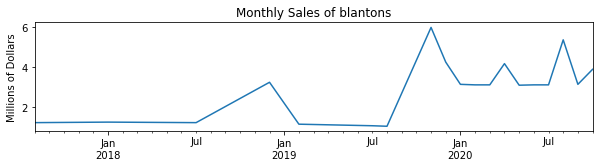

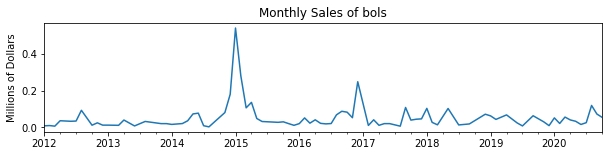

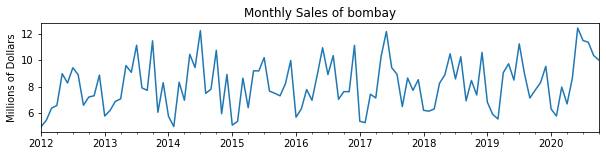

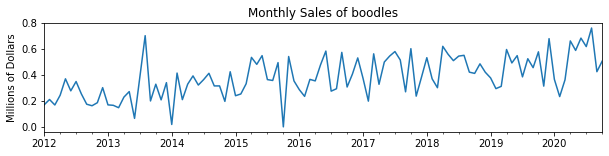

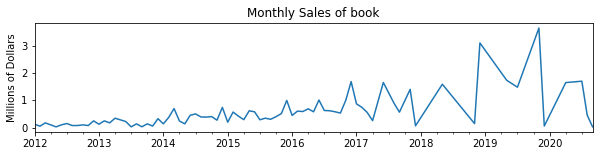

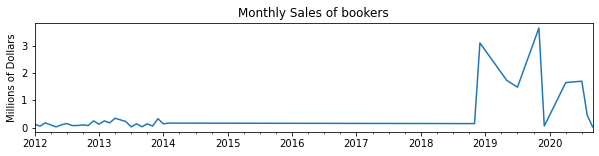

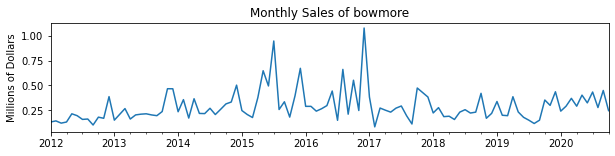

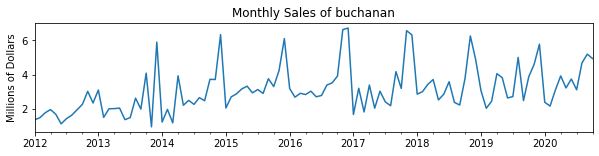

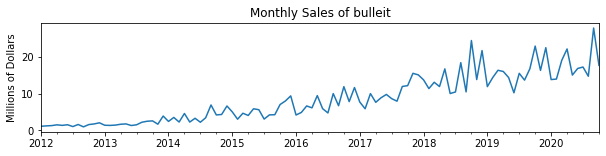

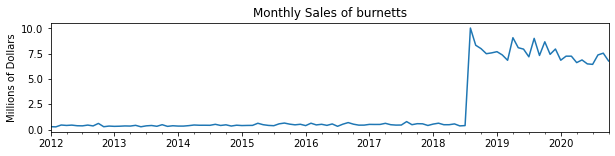

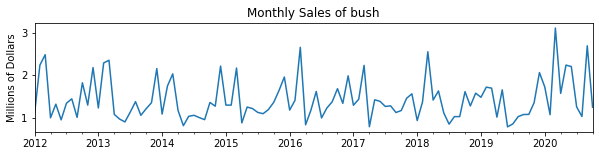

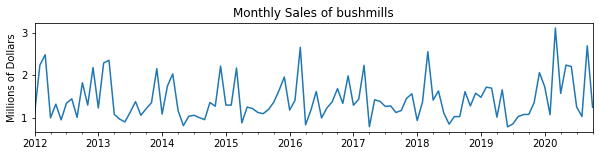

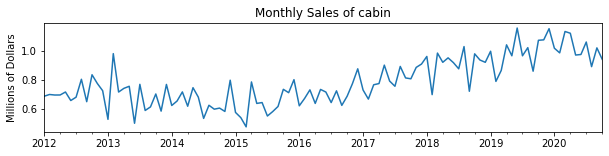

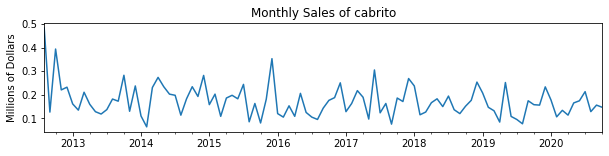

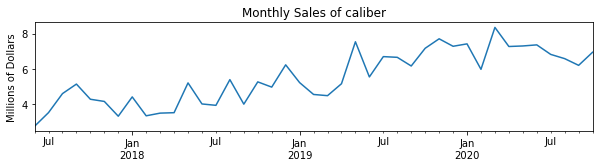

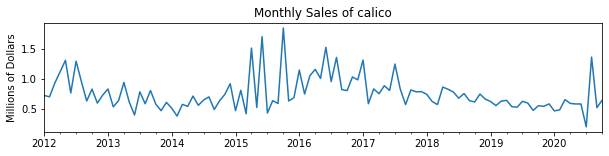

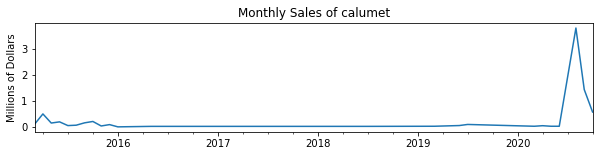

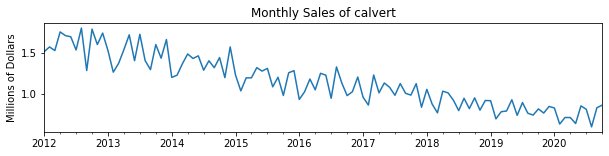

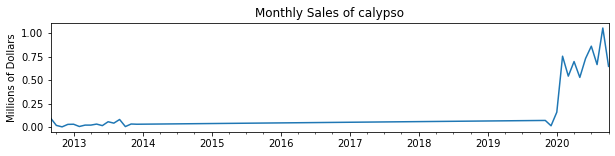

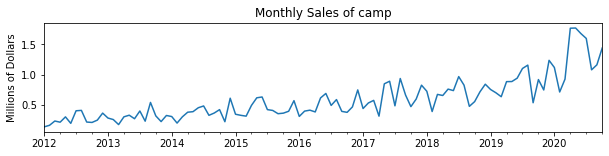

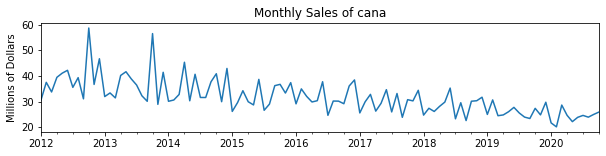

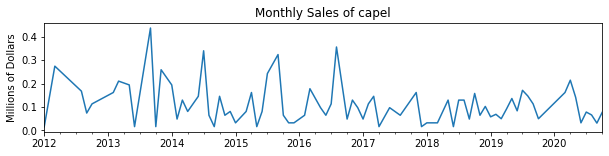

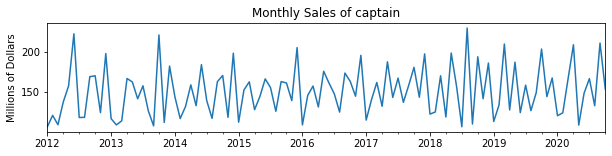

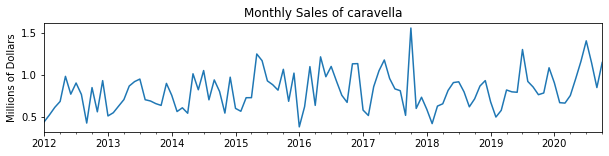

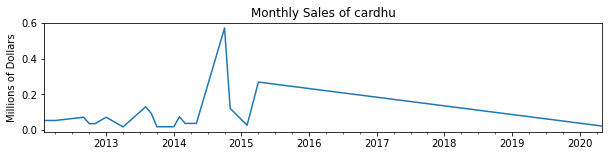

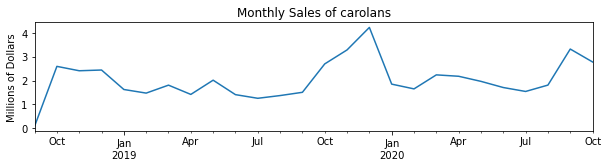

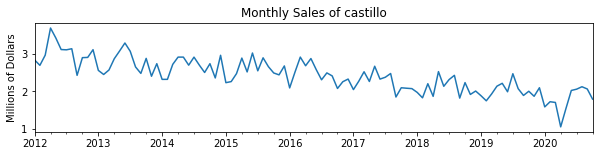

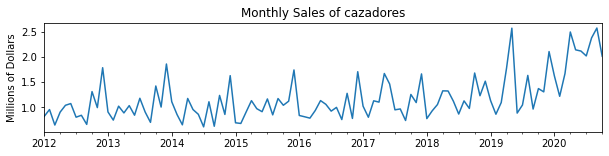

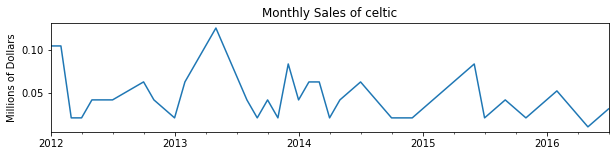

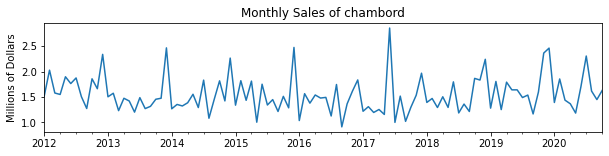

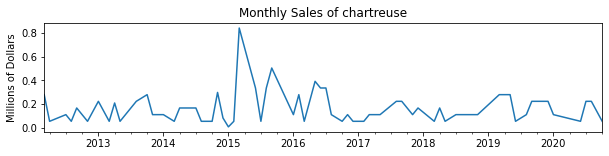

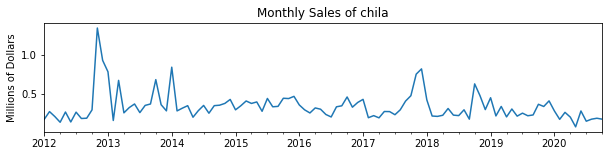

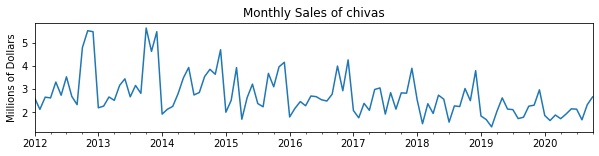

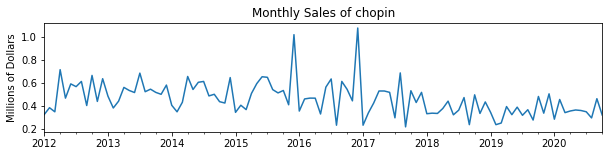

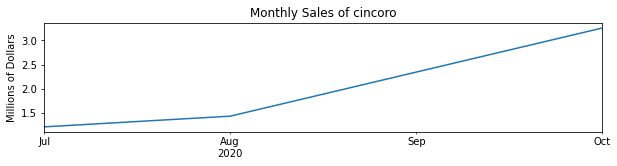

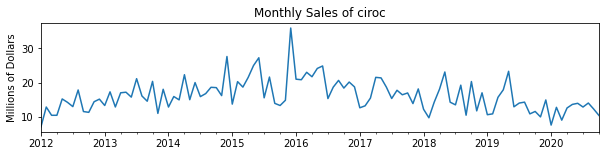

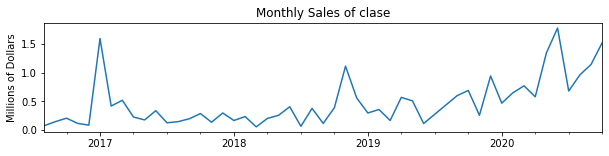

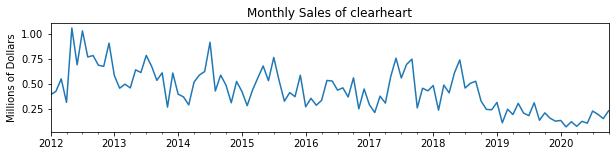

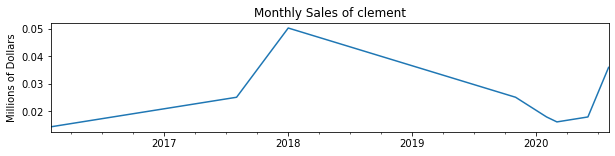

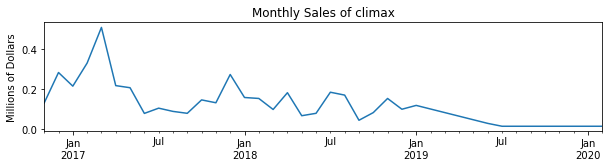

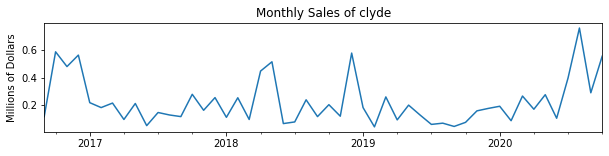

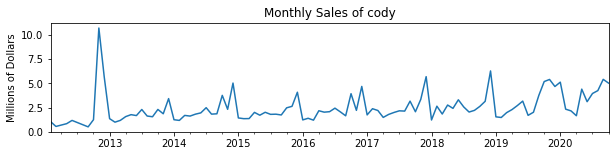

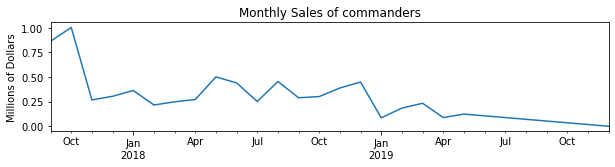

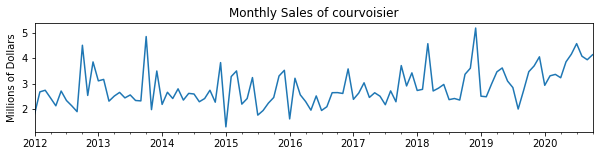

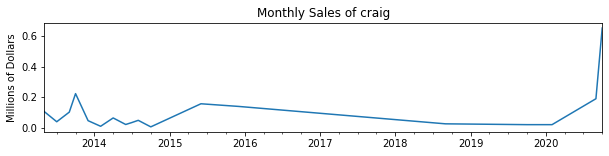

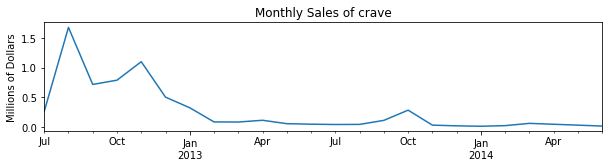

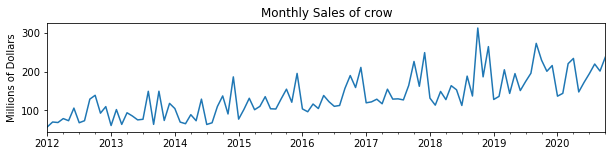

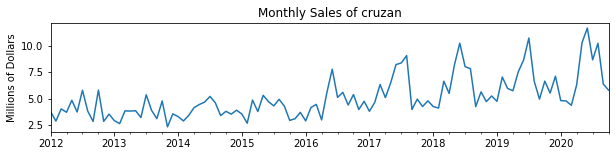

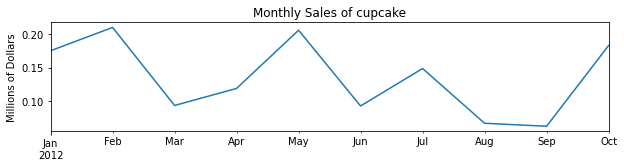

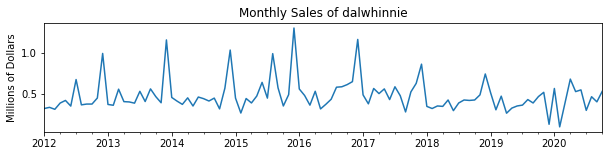

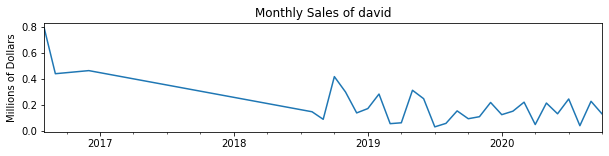

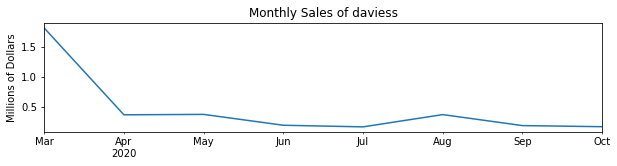

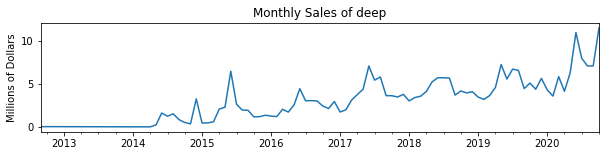

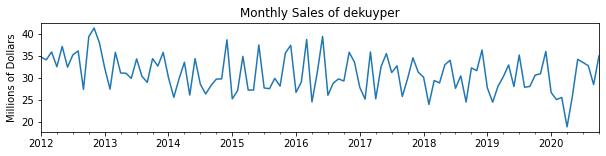

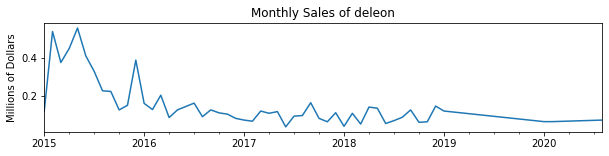

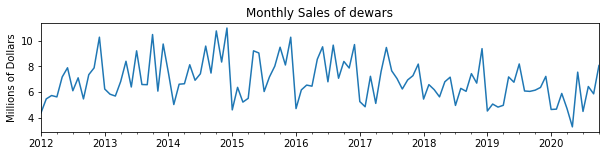

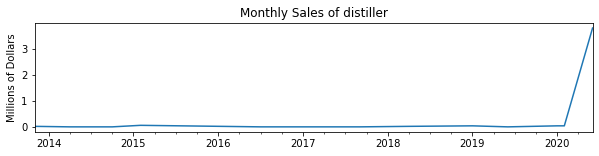

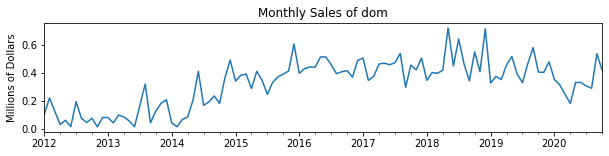

/Users/sunderland20a/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1136: UserWarning: Attempting to set identical left == right == 600.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


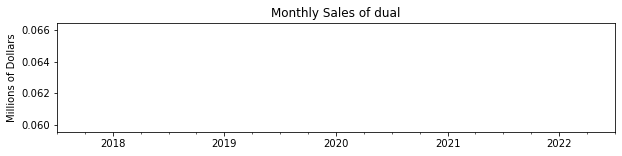

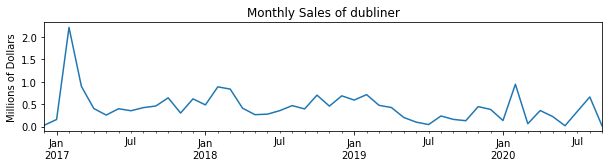

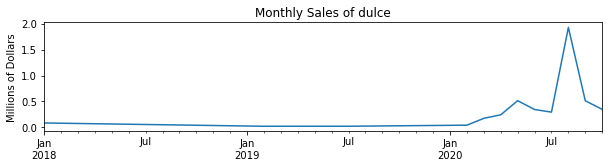

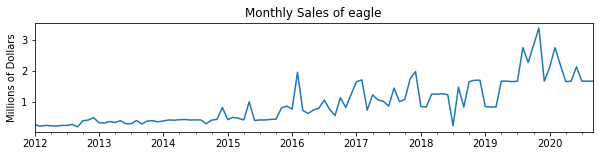

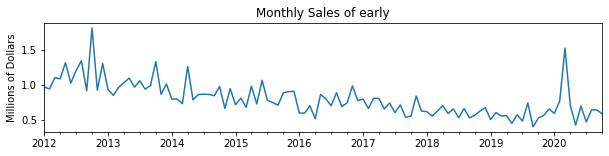

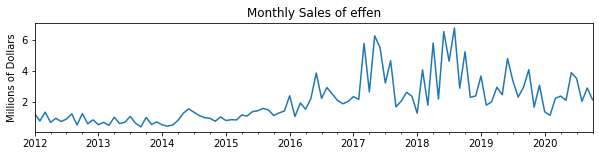

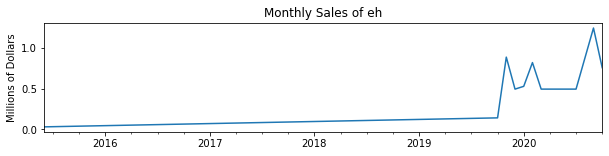

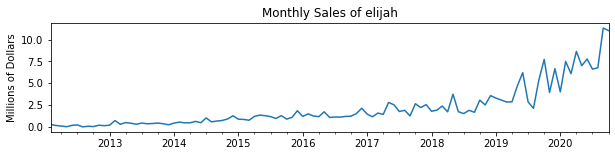

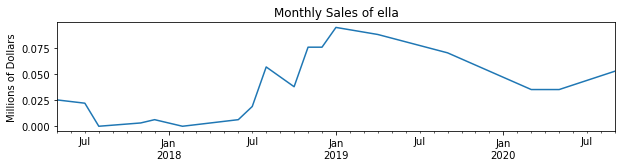

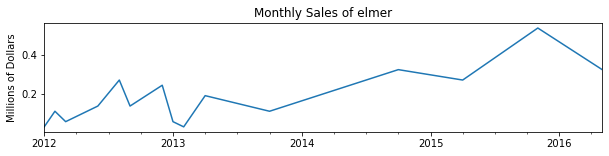

/Users/sunderland20a/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1136: UserWarning: Attempting to set identical left == right == 542.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


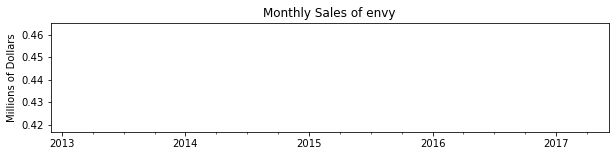

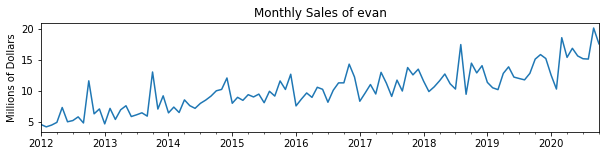

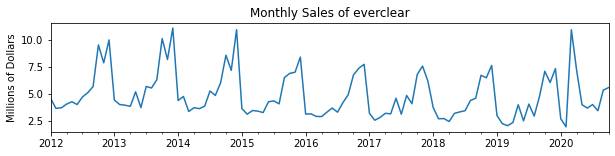

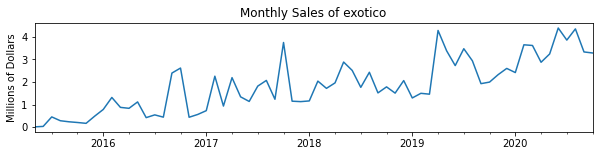

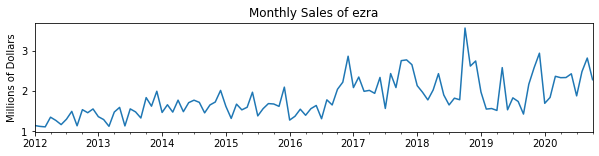

/Users/sunderland20a/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1136: UserWarning: Attempting to set identical left == right == 542.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


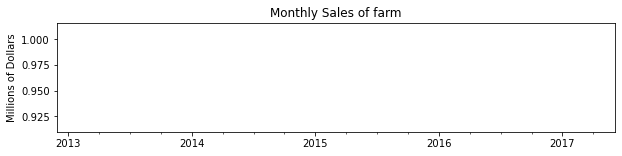

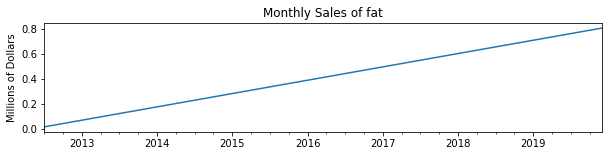

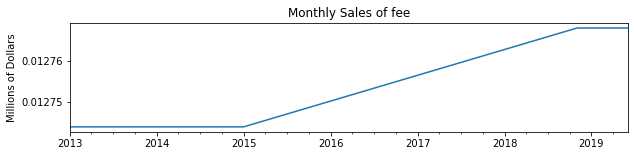

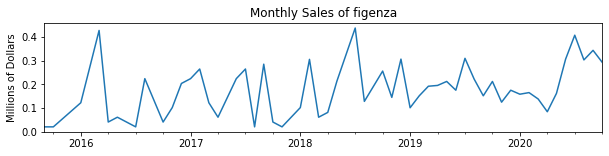

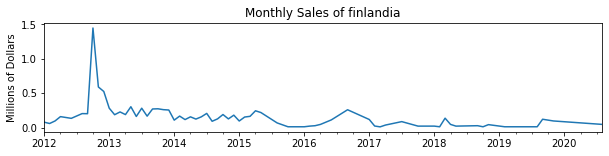

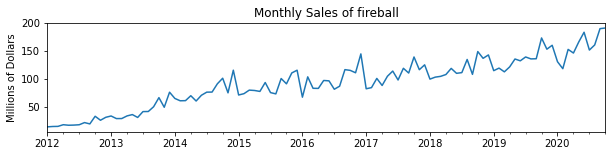

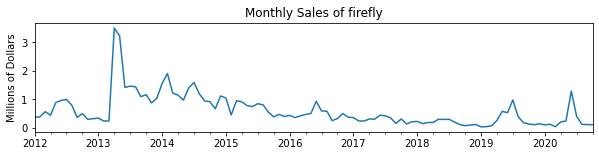

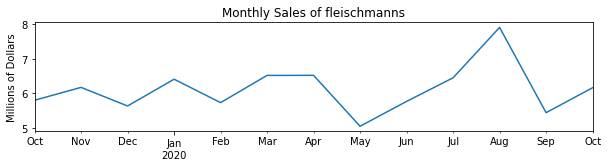

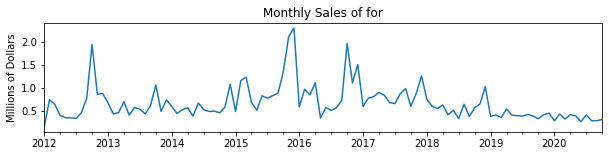

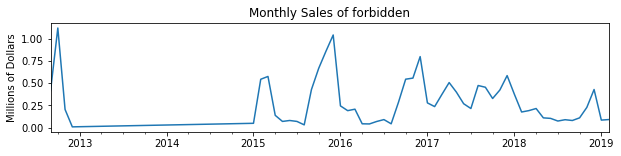

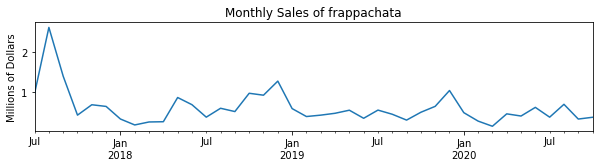

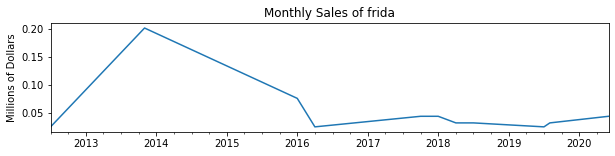

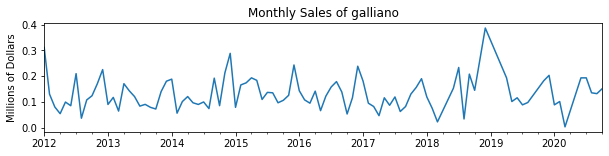

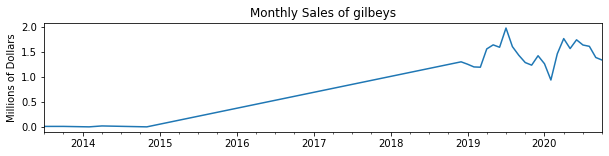

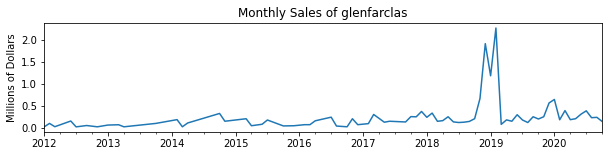

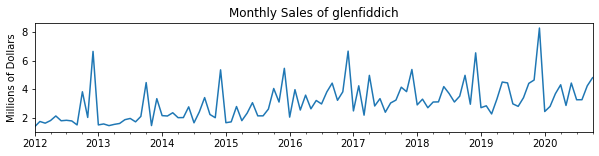

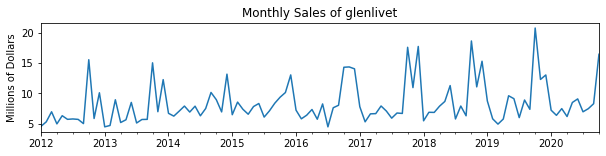

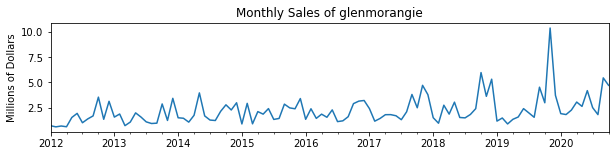

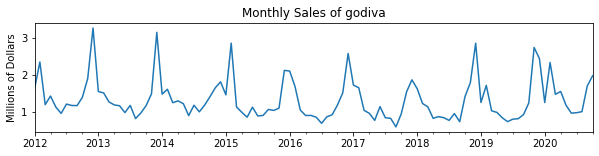

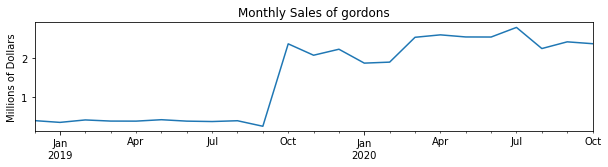

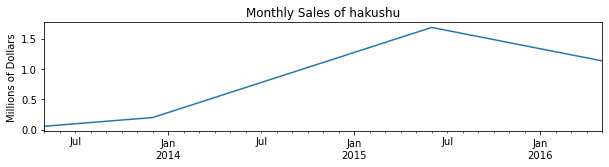

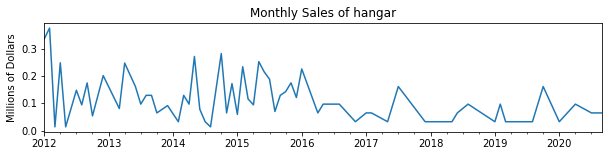

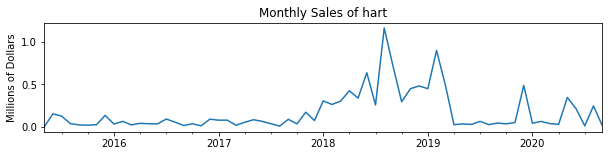

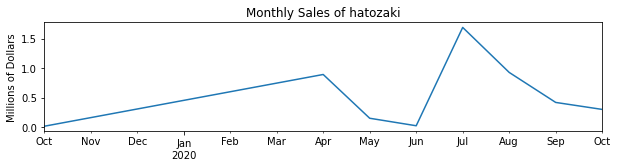

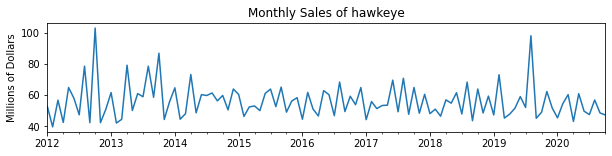

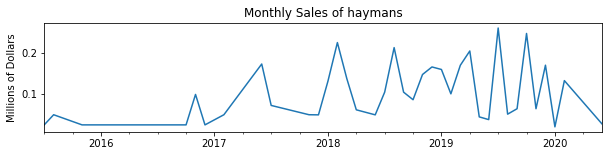

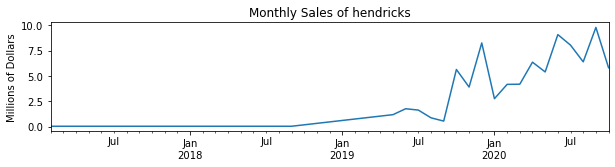

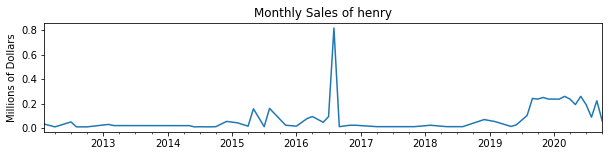

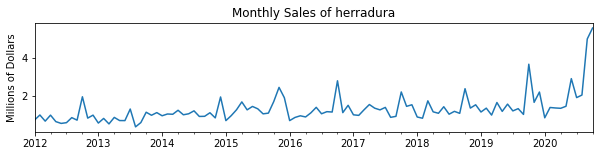

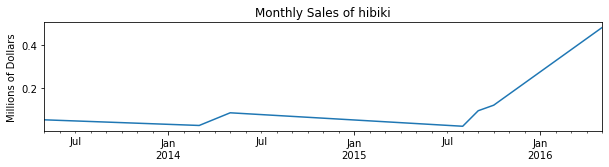

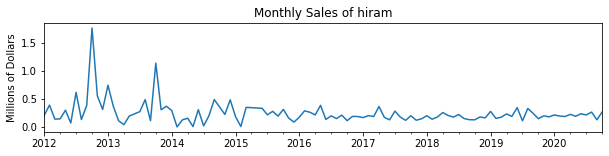

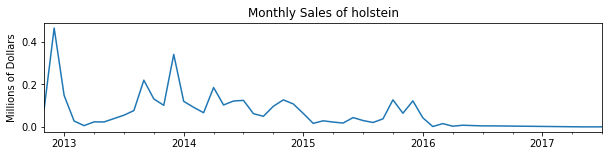

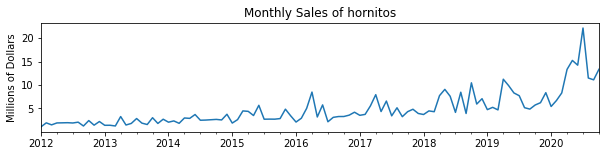

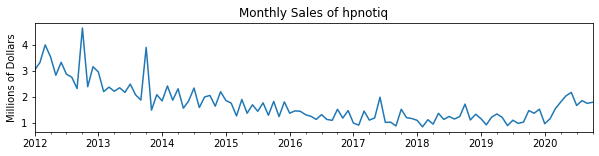

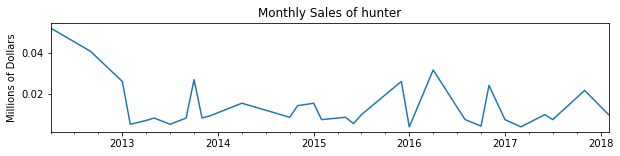

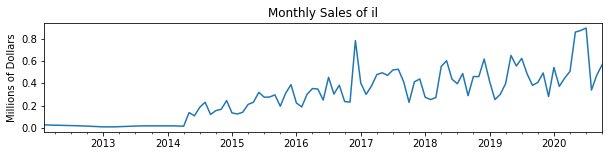

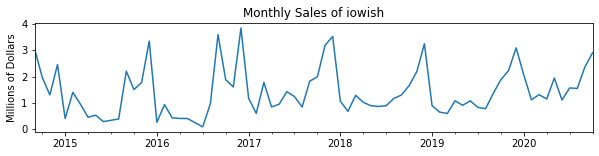

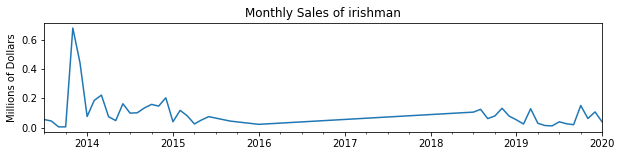

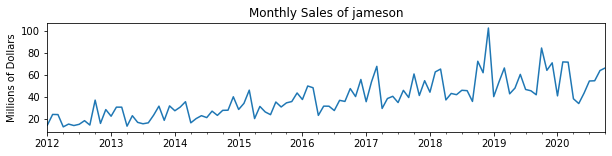

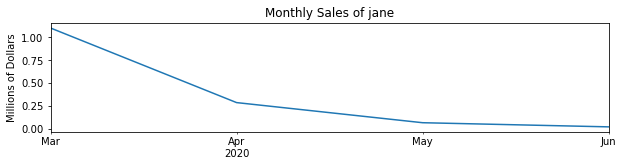

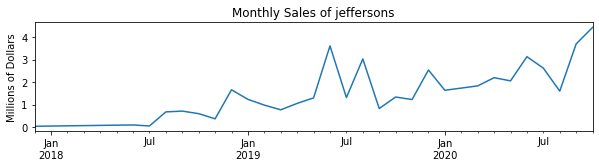

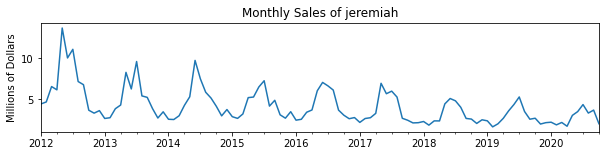

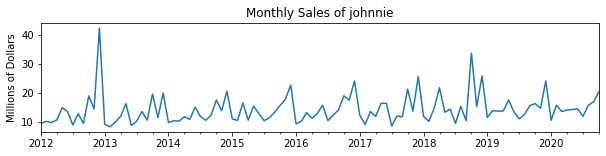

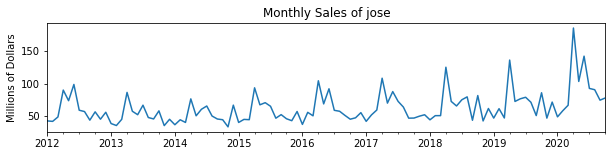

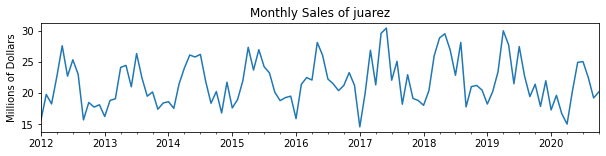

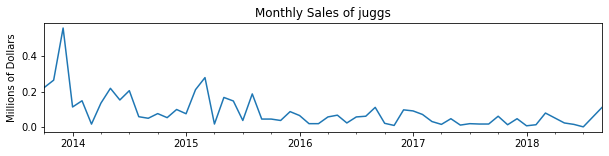

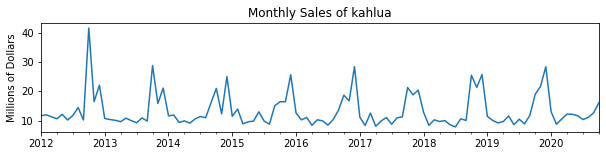

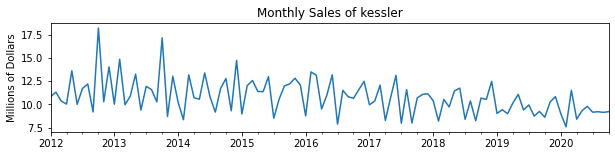

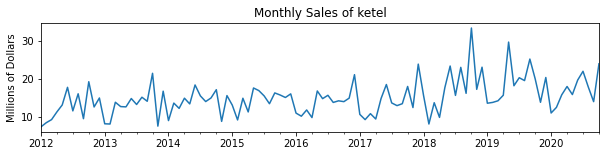

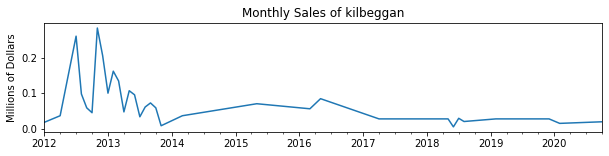

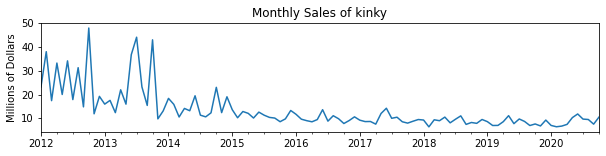

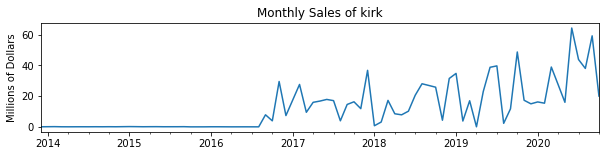

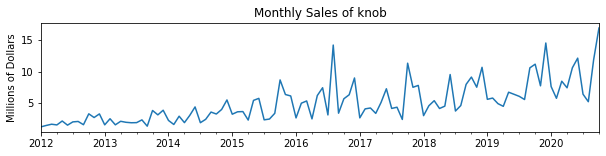

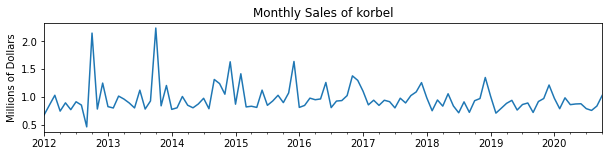

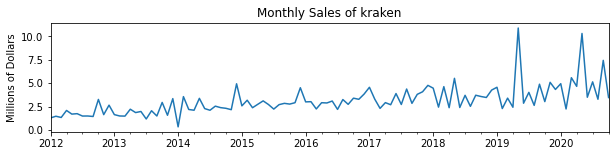

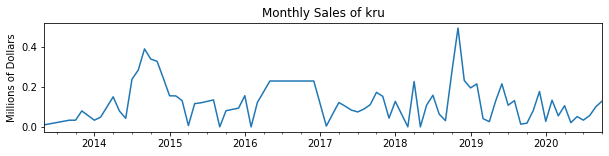

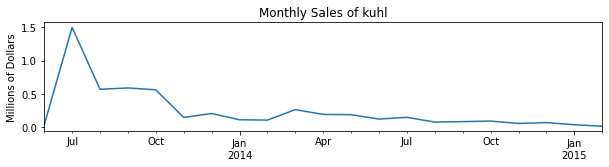

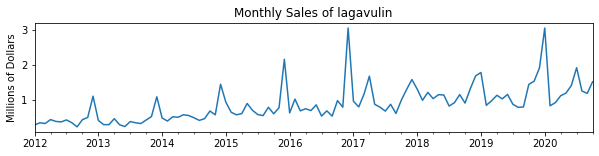

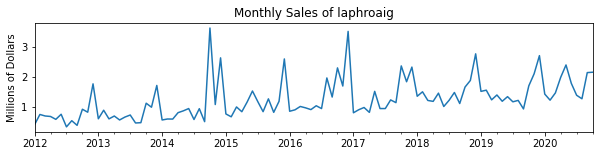

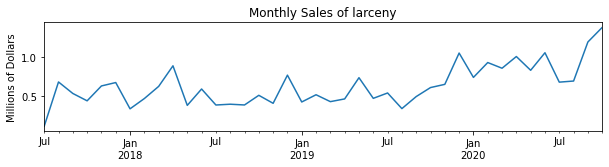

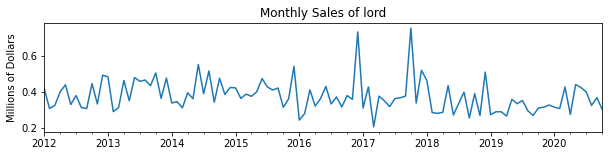

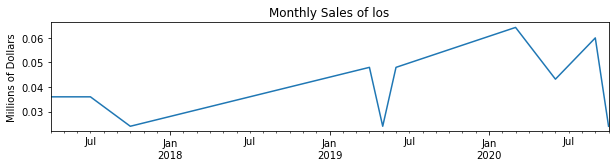

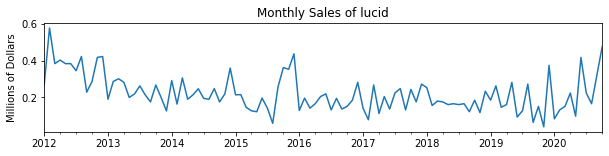

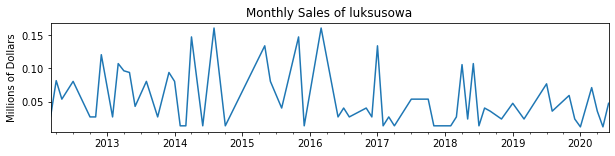

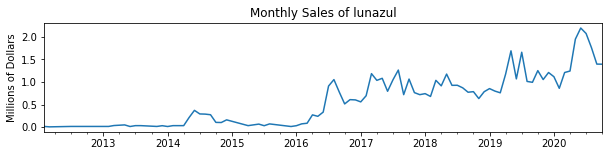

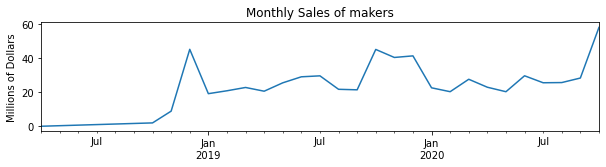

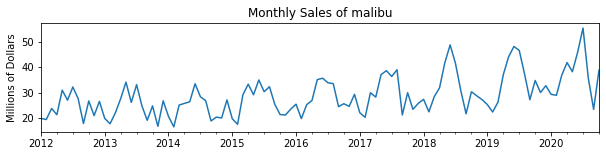

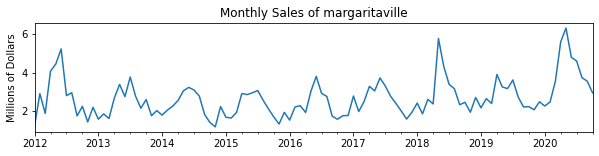

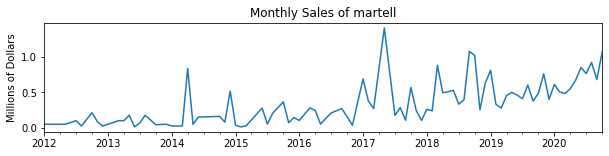

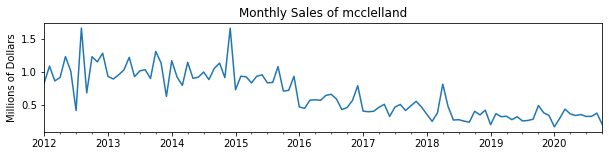

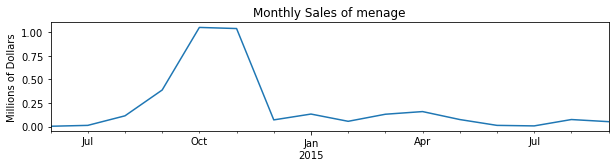

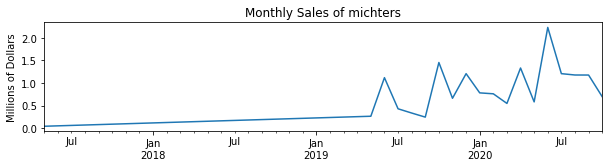

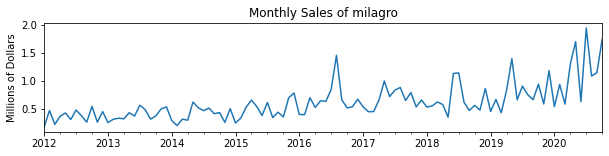

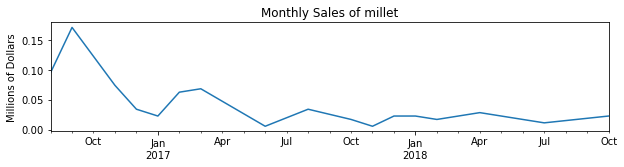

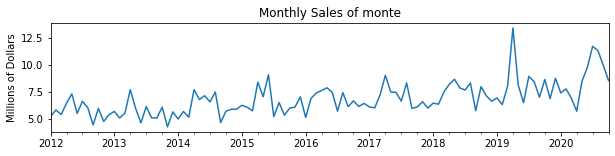

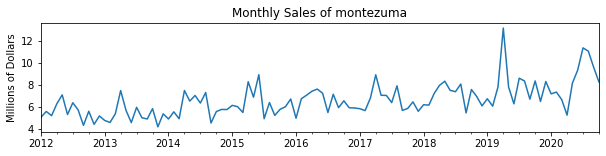

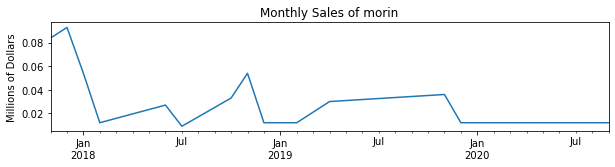

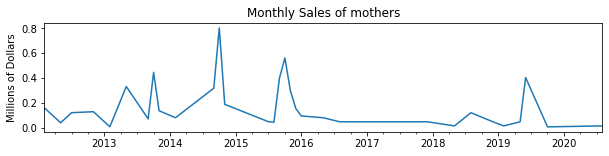

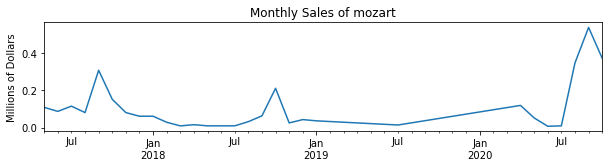

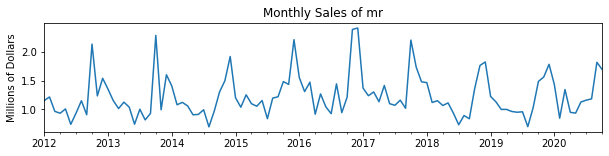

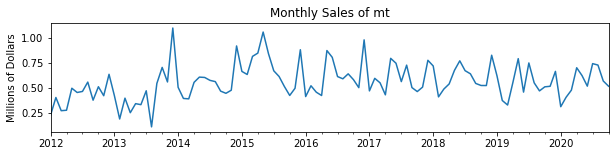

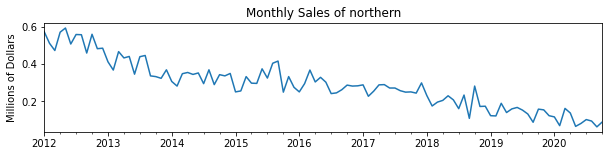

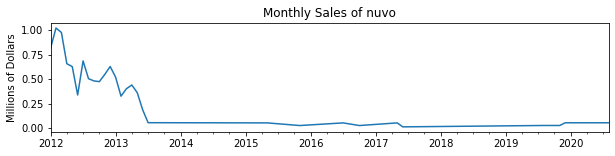

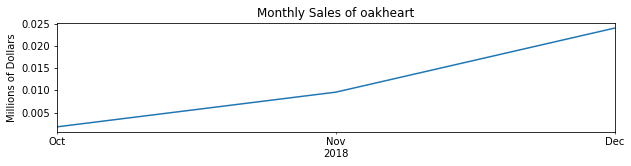

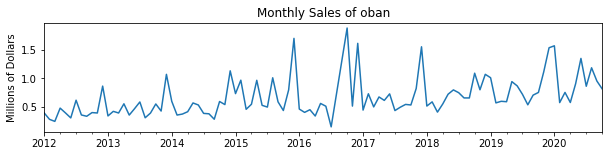

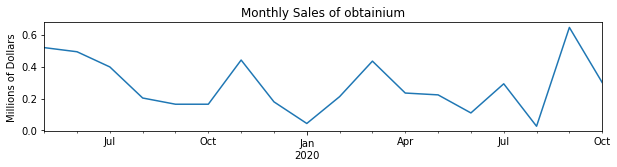

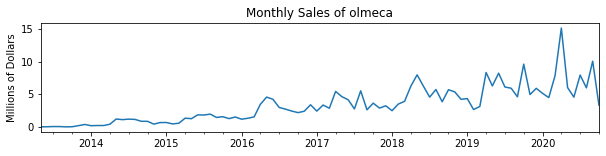

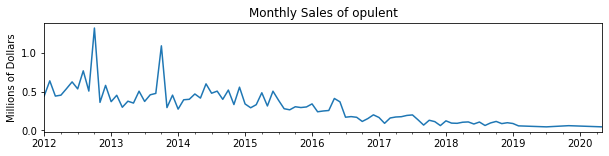

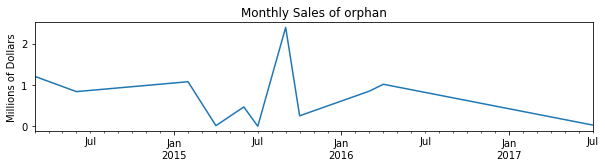

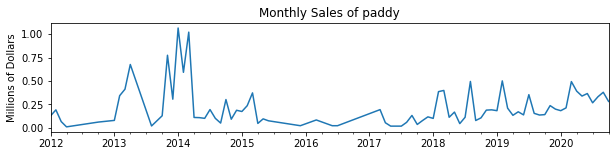

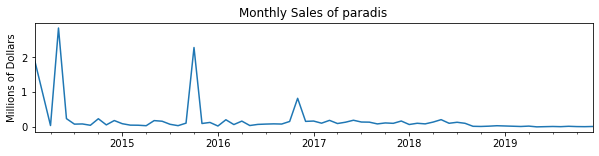

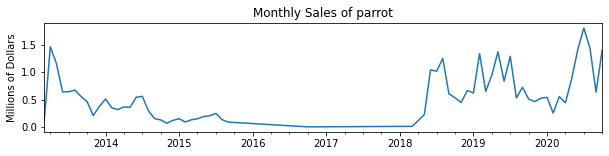

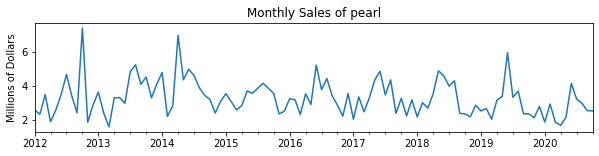

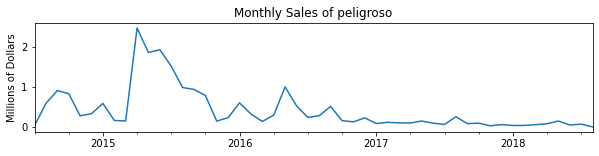

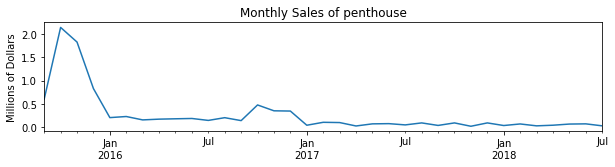

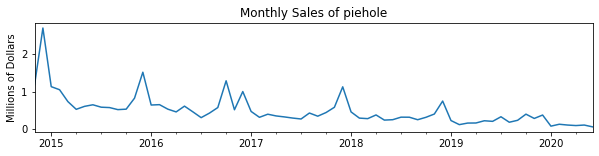

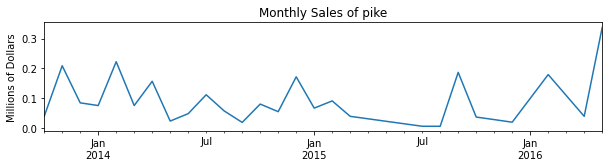

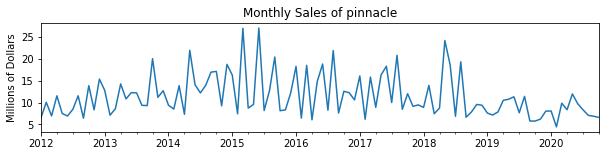

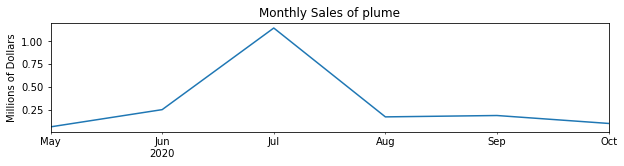

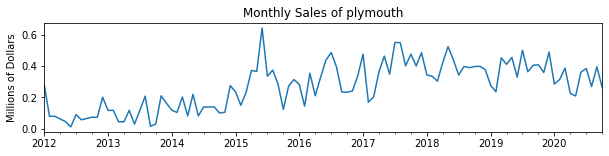

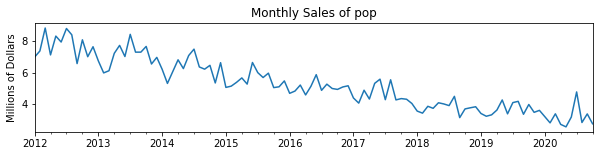

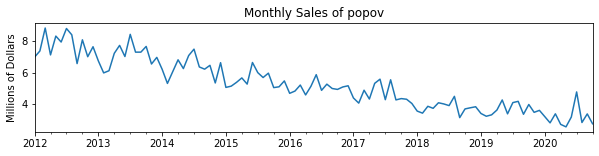

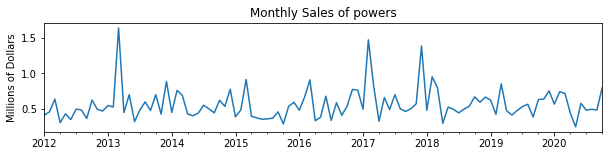

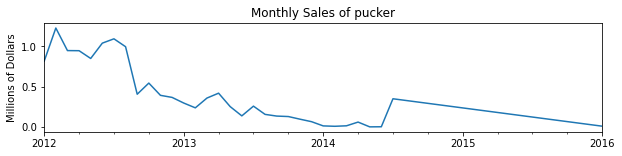

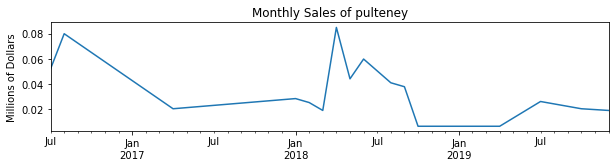

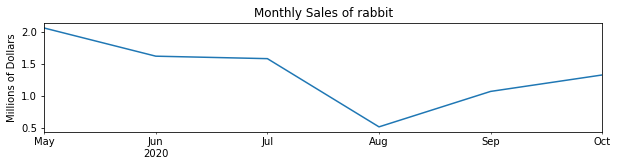

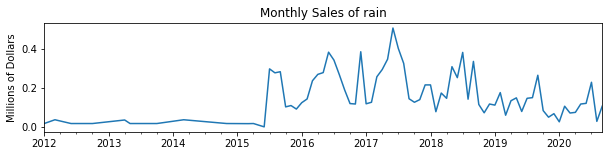

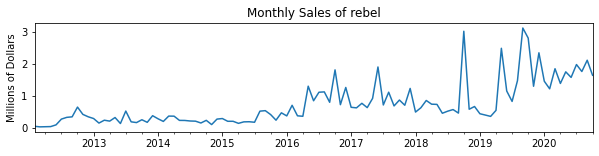

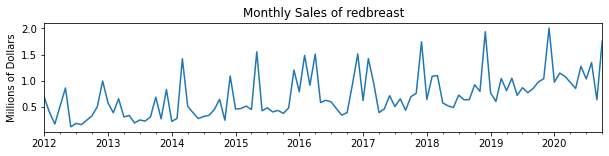

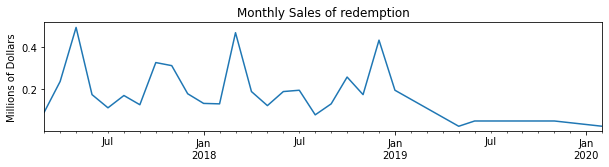

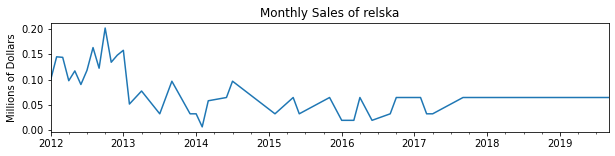

/Users/sunderland20a/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1136: UserWarning: Attempting to set identical left == right == 607.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


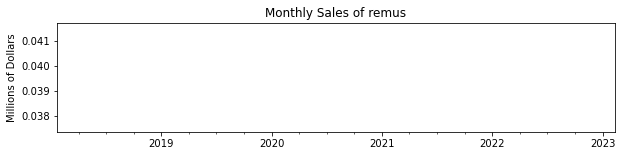

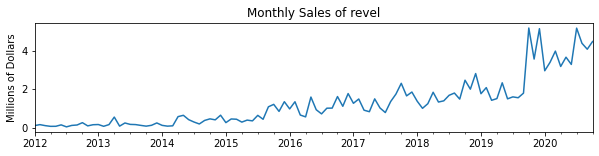

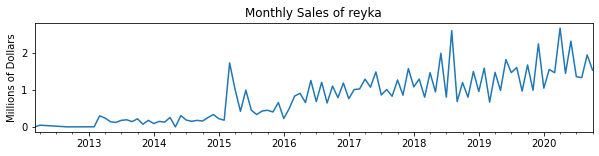

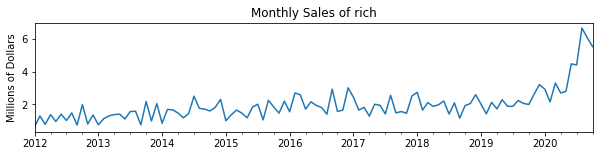

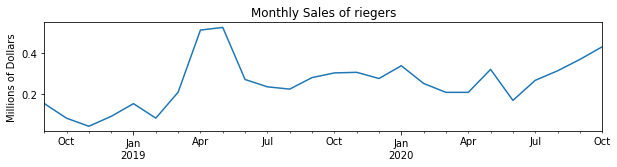

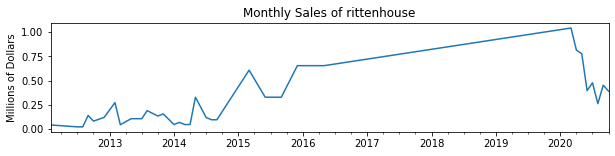

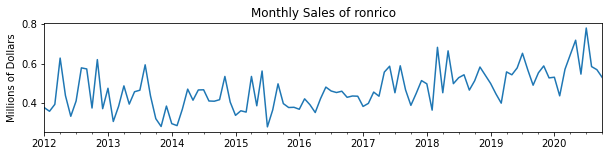

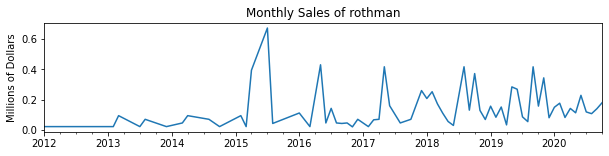

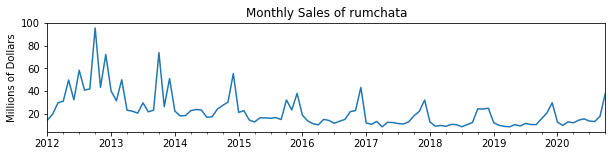

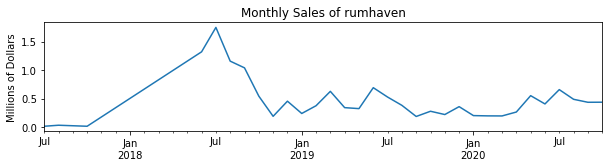

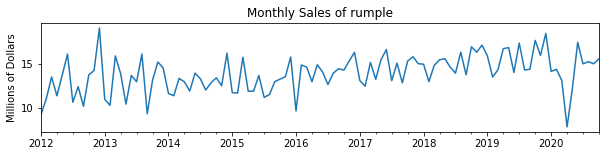

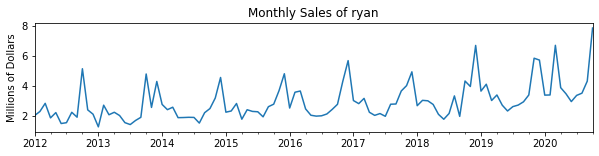

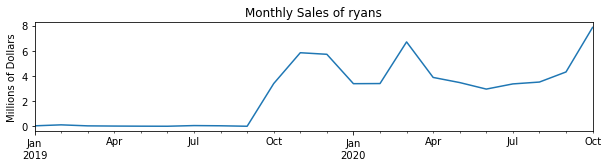

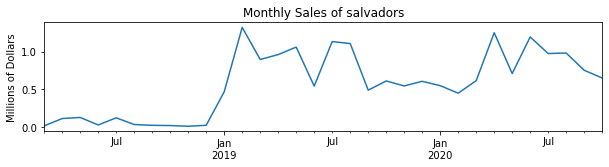

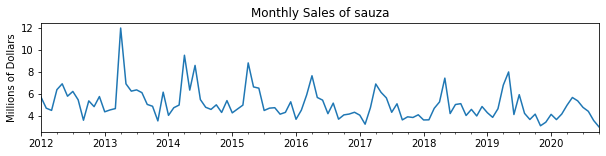

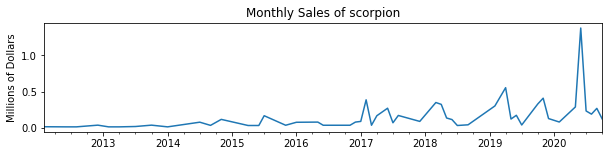

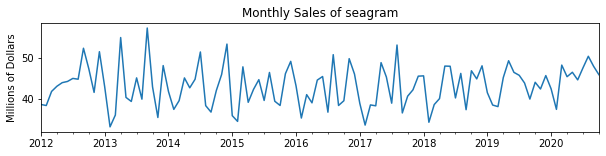

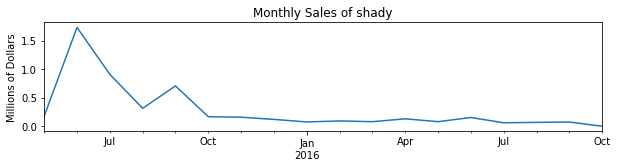

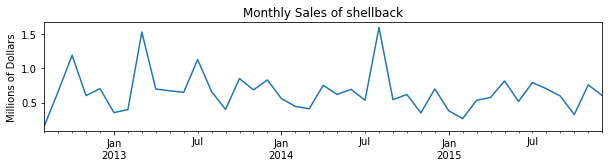

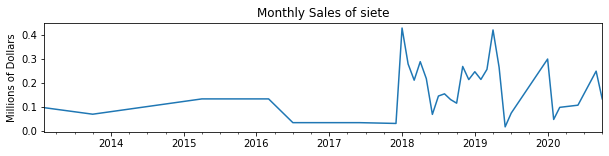

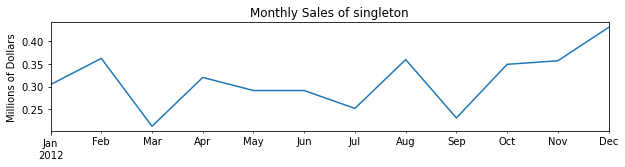

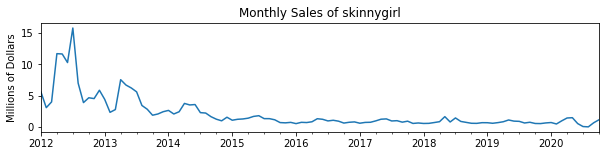

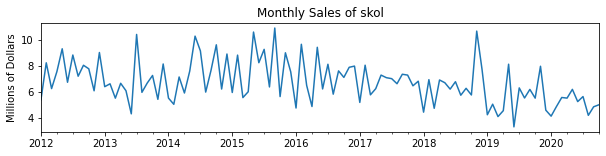

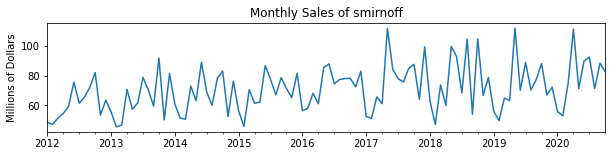

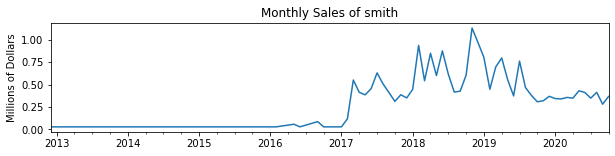

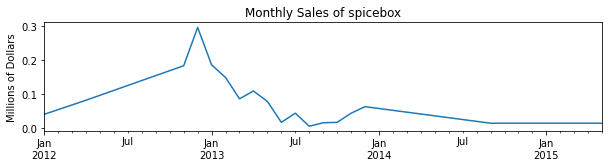

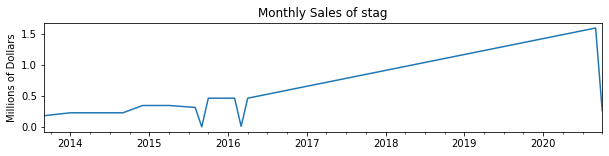

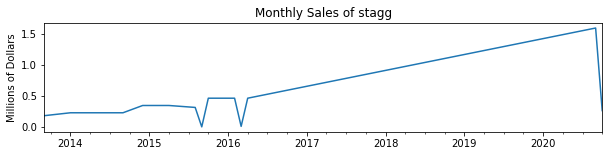

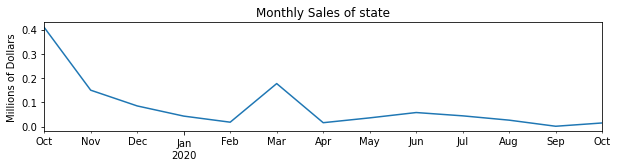

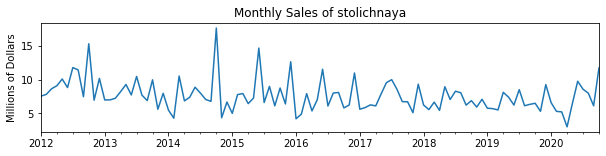

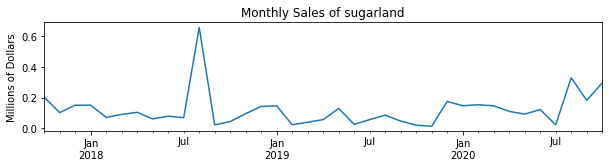

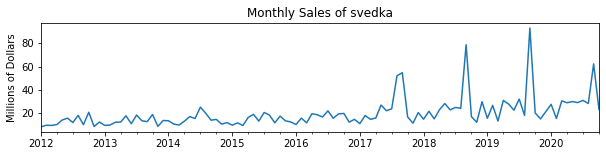

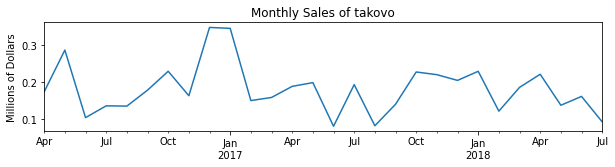

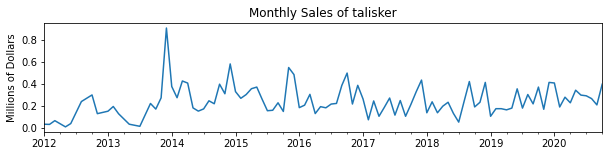

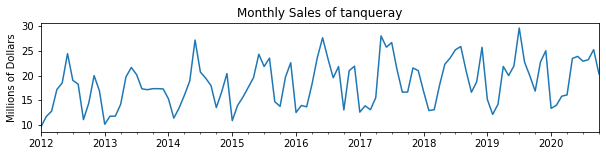

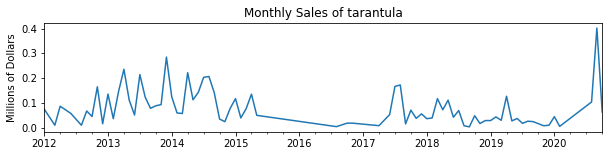

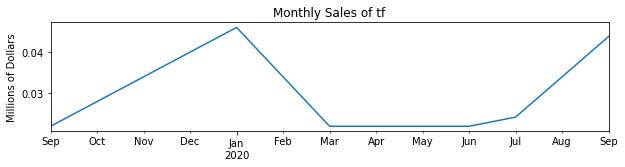

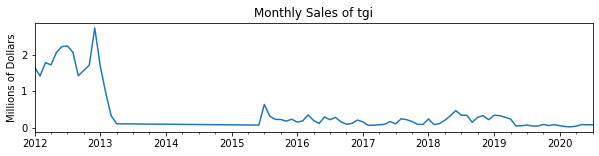

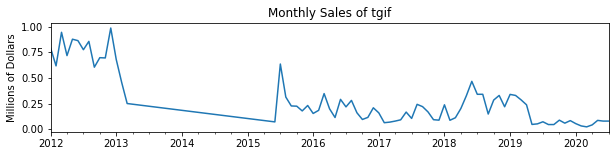

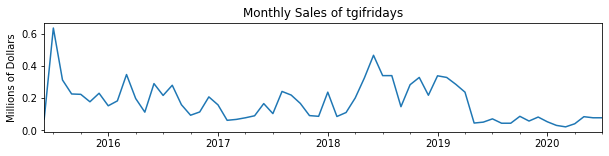

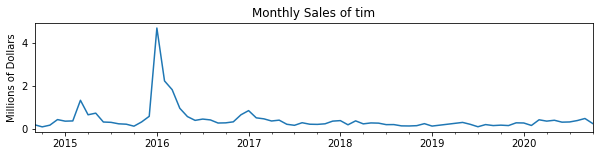

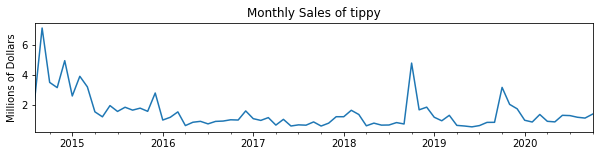

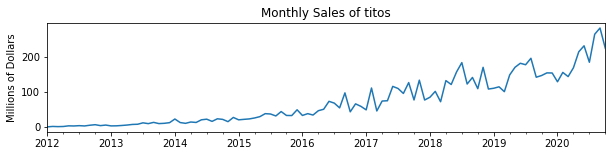

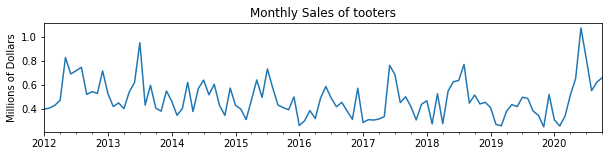

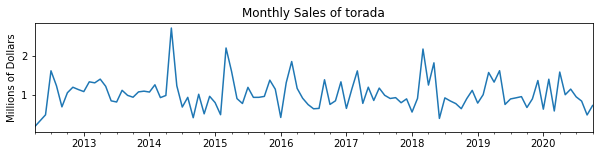

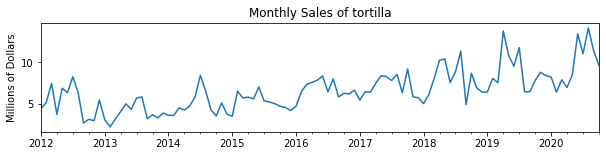

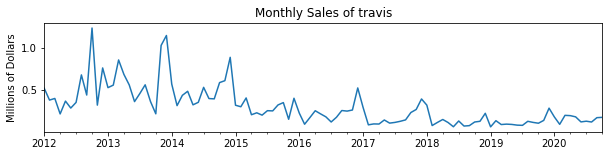

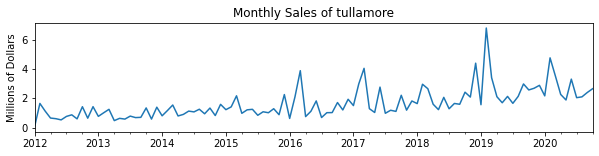

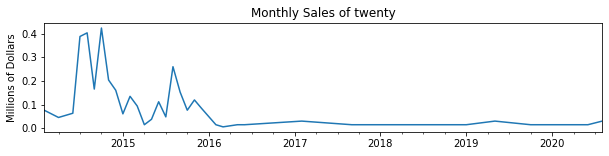

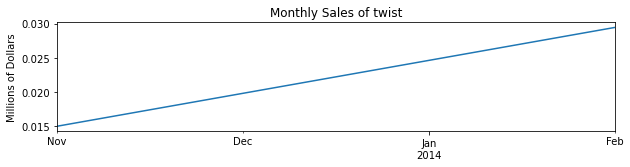

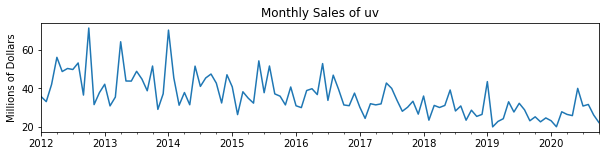

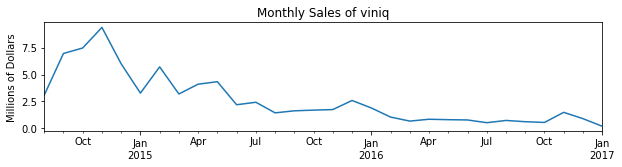

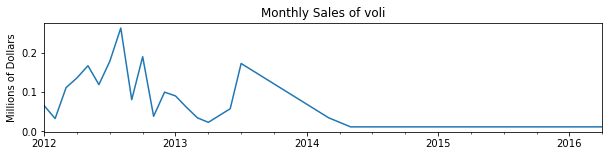

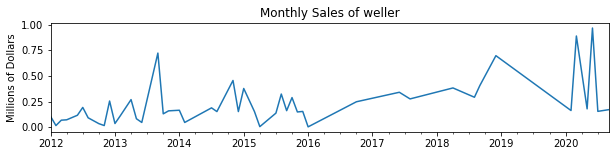

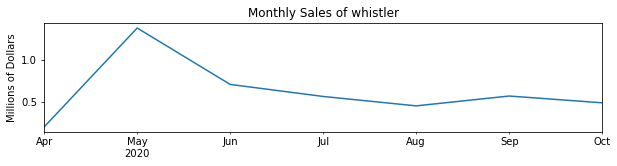

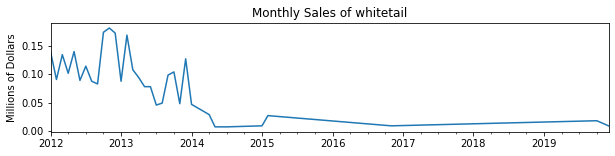

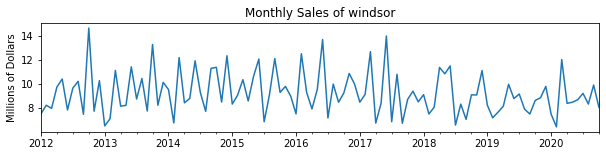

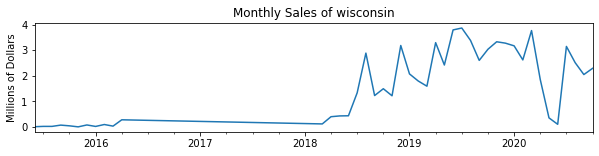

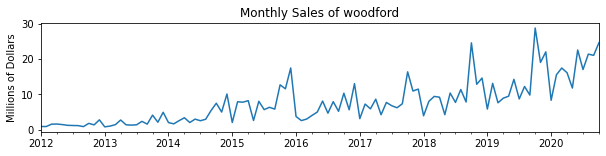

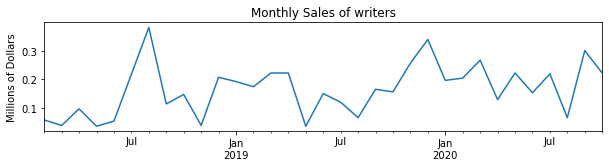

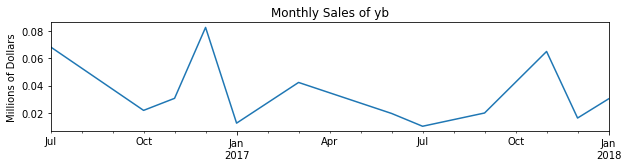

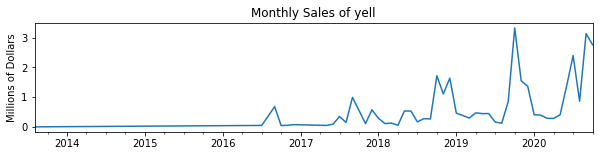

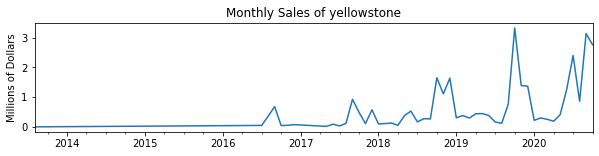

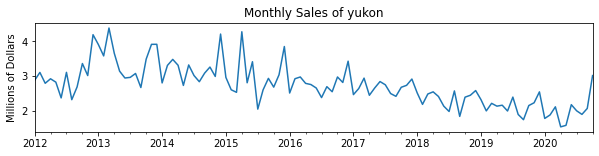

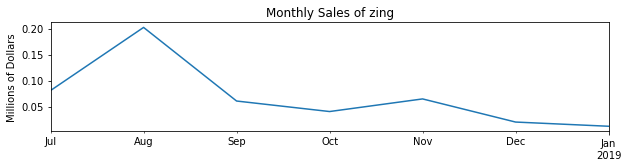

<IPython.core.display.Javascript object>

CPU times: user 1h 8min 34s, sys: 19min 31s, total: 1h 28min 6s
Wall time: 1h 40min 1s


In [12]:
%%time
%%notify

len(lines)
for item in lines:
    try:
        plot_item(item)
    except TypeError:
        pass

Next step: Include code for engineering the Product_lines column, and redo plot_item(item)